In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import skew
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
import xgboost as xgb

//anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
### Root Mean Squared Log Error function for GridSearch
from sklearn.metrics import make_scorer
def rmsle(predicted, actual):
    assert(len(predicted) == len(actual))
    p = np.log(np.array(predicted) + 1)
    a = np.log(np.array(actual) + 1)
    return (((p - a)**2).sum() / len(predicted))**0.5
rmsle_loss = make_scorer(rmsle, greater_is_better=False)

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
### Conversion to float32 and int32
for c, dtype in zip(train.columns, train.dtypes):
    if dtype == np.float64:
        train[c] = train[c].astype(np.float32)
for c, dtype in zip(test.columns, test.dtypes):
    if dtype == np.float64:
        test[c] = test[c].astype(np.float32)
for c, dtype in zip(train.columns, train.dtypes):
    if dtype == np.int64:
        train[c] = train[c].astype(np.int32)
for c, dtype in zip(test.columns, test.dtypes):
    if dtype == np.int64:
        test[c] = test[c].astype(np.int32)

In [5]:
cats = ['Alley', 'BldgType', 'BsmtCond', 'BsmtExposure', 
        'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'CentralAir',
        'Condition1', 'Condition2', 'Electrical', 'ExterCond', 
        'Exterior1st', 'Exterior2nd', 'ExterQual', 'Fence', 
        'FireplaceQu', 'Foundation', 'Functional', 'GarageCond', 
        'GarageFinish', 'GarageQual', 'GarageType', 'Heating', 
        'HeatingQC', 'HouseStyle', 'KitchenQual', 'LandContour', 
        'LandSlope', 'LotConfig', 'LotShape', 'MasVnrType', 
        'MiscFeature', 'MoSold', 'MSSubClass', 'MSZoning', 
        'Neighborhood', 'PavedDrive', 'PoolQC', 'RoofMatl', 'RoofStyle', 
        'SaleCondition', 'SaleType', 'Street', 'Utilities']
nums = ['GarageYrBlt', 'LotFrontage', 'MasVnrArea', '1stFlrSF', 
        '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1', 
        'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 
        'BsmtUnfSF', 'EnclosedPorch', 'Fireplaces', 'FullBath', 
        'GarageArea', 'GarageCars', 'GrLivArea', 'HalfBath', 
        'KitchenAbvGr', 'LotArea', 'LowQualFinSF', 'MiscVal', 
        'OpenPorchSF', 'OverallCond', 'OverallQual', 'PoolArea', 
        'ScreenPorch', 'TotalBsmtSF', 'TotRmsAbvGrd', 
        'WoodDeckSF', 'YearBuilt', 'YearRemodAdd', 'YrSold']

In [6]:
### Fill NAs with -1 and convert MSSubClass to strings
### since they are integers but are actually
### unordered categorical
# train = train.fillna(-1)
train['MSSubClass'] = train['MSSubClass'].astype(str)

In [7]:
#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

skewed_feats = train[nums].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

train[skewed_feats] = np.log1p(train[skewed_feats])

In [8]:
features = [c for c in train.columns if c not in['Id','SalePrice']]

In [9]:
from sklearn.feature_extraction import DictVectorizer
dv = DictVectorizer().fit(train[cats].T.to_dict().values())
cat_matrix = dv.transform(train[cats].T.to_dict().values())

In [10]:
train[nums] = train[nums].fillna(train[nums].mean())

In [11]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=3)
# poly_matrix = poly.fit_transform(data_matrix.toarray())
poly_matrix = poly.fit_transform(train[nums])

In [12]:
data_matrix = hstack([cat_matrix, poly_matrix])

In [13]:
X_train, X_test, y_train, y_test = train_test_split(data_matrix, train['SalePrice'], test_size=0.33, random_state=42)

In [14]:
%%time
d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

CPU times: user 2.2 s, sys: 134 ms, total: 2.34 s
Wall time: 2.34 s


In [21]:
%%time
from sklearn.model_selection import GridSearchCV
boost = xgb.XGBRegressor()
n_estimators = [50, 100, 200, 300]
tuned_parameters = dict(n_estimators=n_estimators)
grid = GridSearchCV(boost, tuned_parameters, cv=3, scoring=rmsle_loss, n_jobs=-1, verbose=2)
grid.fit(data_matrix, train['SalePrice'])

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] n_estimators=50 .................................................
[CV] n_estimators=50 .................................................
[CV] n_estimators=50 .................................................
[CV] n_estimators=100 ................................................
[CV] .................................. n_estimators=50, total=  22.1s
[CV] n_estimators=100 ................................................
[CV] .................................. n_estimators=50, total=  22.4s
[CV] n_estimators=100 ................................................
[CV] .................................. n_estimators=50, total=  22.7s
[CV] n_estimators=200 ................................................
[CV] ................................. n_estimators=100, total=  42.0s
[CV] n_estimators=200 ................................................
[CV] ................................. n_estimators=100, total=  43.0s
[CV] n_estimators

[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  3.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  3.8min finished


CPU times: user 1min 27s, sys: 553 ms, total: 1min 27s
Wall time: 5min 14s


In [22]:
# summarize results
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.010294 using {'n_estimators': 300}
-0.011697 (0.000925) with: {'n_estimators': 50}
-0.010338 (0.001074) with: {'n_estimators': 100}
-0.010303 (0.001026) with: {'n_estimators': 200}
-0.010294 (0.001015) with: {'n_estimators': 300}


//anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


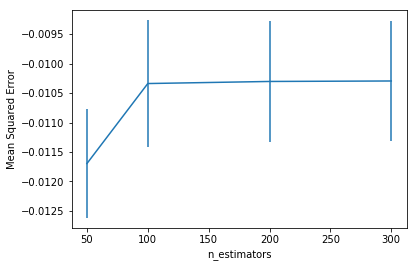

In [23]:
# plot
# scores = np.array(means).reshape(len(learning_rate), len(max_depth), len(n_estimators))
# for i, value in enumerate(learning_rate):
#     plt.plot(n_estimators, scores[i][1], label='learning_rate: ' + str(value)) 
plt.errorbar(n_estimators, means, yerr=stds)
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Mean Squared Error')
# print scores

In [27]:
%%time
from sklearn.model_selection import GridSearchCV
boost = xgb.XGBRegressor(n_estimators=100)
max_depth = [1,2,5,7,9]
tuned_parameters = dict(max_depth=max_depth)
grid = GridSearchCV(boost, tuned_parameters, cv=3, scoring=rmsle_loss, n_jobs=-1, verbose=2)
grid.fit(data_matrix, train['SalePrice'])

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] max_depth=1 .....................................................
[CV] max_depth=1 .....................................................
[CV] max_depth=1 .....................................................
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=1, total=  17.5s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=1, total=  17.7s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=1, total=  18.0s
[CV] max_depth=5 .....................................................
[CV] ...................................... max_depth=2, total=  30.1s
[CV] max_depth=5 .....................................................
[CV] ...................................... max_depth=2, total=  32.1s
[CV] max_depth=5 

[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  4.3min finished


CPU times: user 22.9 s, sys: 423 ms, total: 23.3 s
Wall time: 4min 37s


In [28]:
# summarize results
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.010459 using {'max_depth': 2}
-0.011284 (0.000935) with: {'max_depth': 1}
-0.010459 (0.000904) with: {'max_depth': 2}
-0.010483 (0.001046) with: {'max_depth': 5}
-0.010615 (0.000922) with: {'max_depth': 7}
-0.010626 (0.000947) with: {'max_depth': 9}


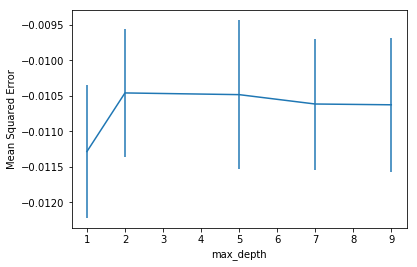

In [29]:
# plot
plt.errorbar(max_depth, means, yerr=stds)
plt.legend()
plt.xlabel('max_depth')
plt.ylabel('Mean Squared Error')
# print scores

In [30]:
%%time
from sklearn.model_selection import GridSearchCV
boost = xgb.XGBRegressor(n_estimators=100, max_depth=2)
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
tuned_parameters = dict(learning_rate=learning_rate)
grid = GridSearchCV(boost, tuned_parameters, cv=3, scoring=rmsle_loss, n_jobs=-1, verbose=2)
grid.fit(data_matrix, train['SalePrice'])

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] learning_rate=0.0001 ............................................
[CV] learning_rate=0.0001 ............................................
[CV] learning_rate=0.0001 ............................................
[CV] learning_rate=0.001 .............................................
[CV] ............................. learning_rate=0.0001, total=  18.9s
[CV] ............................. learning_rate=0.0001, total=  18.9s
[CV] learning_rate=0.001 .............................................
[CV] learning_rate=0.001 .............................................
[CV] ............................. learning_rate=0.0001, total=  19.2s
[CV] learning_rate=0.01 ..............................................
[CV] .............................. learning_rate=0.001, total=  19.1s
[CV] learning_rate=0.01 ..............................................
[CV] .............................. learning_rate=0.001, total=  20.9s
[CV] learning_rat

[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  2.5min finished


CPU times: user 25 s, sys: 490 ms, total: 25.5 s
Wall time: 2min 56s


In [31]:
# summarize results
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.010459 using {'learning_rate': 0.1}
-2.087494 (0.000741) with: {'learning_rate': 0.0001}
-1.612606 (0.000885) with: {'learning_rate': 0.001}
-0.392498 (0.000492) with: {'learning_rate': 0.01}
-0.010459 (0.000904) with: {'learning_rate': 0.1}
-0.010792 (0.000658) with: {'learning_rate': 0.2}
-0.011168 (0.000909) with: {'learning_rate': 0.3}


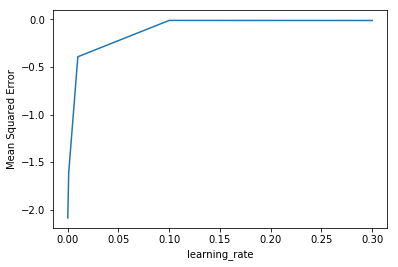

In [32]:
# plot
plt.errorbar(learning_rate, means, yerr=stds)
plt.legend()
plt.xlabel('learning_rate')
plt.ylabel('Mean Squared Error')
# print scores

In [33]:
%%time
from sklearn.model_selection import GridSearchCV
boost = xgb.XGBRegressor(n_estimators=100, max_depth=2, learning_rate=0.1)
subsample = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
tuned_parameters = dict(subsample=subsample)
grid = GridSearchCV(boost, tuned_parameters, cv=3, scoring=rmsle_loss, n_jobs=-1, verbose=2)
grid.fit(data_matrix, train['SalePrice'])

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] subsample=0.1 ...................................................
[CV] subsample=0.1 ...................................................
[CV] subsample=0.1 ...................................................
[CV] subsample=0.2 ...................................................
[CV] .................................... subsample=0.1, total=  13.1s
[CV] subsample=0.2 ...................................................
[CV] .................................... subsample=0.1, total=  13.1s
[CV] subsample=0.2 ...................................................
[CV] .................................... subsample=0.1, total=  13.4s
[CV] subsample=0.3 ...................................................
[CV] .................................... subsample=0.2, total=  16.1s
[CV] subsample=0.3 ...................................................
[CV] .................................... subsample=0.2, total=  15.0s
[CV] subsample=0.

[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  3.3min finished


CPU times: user 25.1 s, sys: 632 ms, total: 25.7 s
Wall time: 3min 43s


In [34]:
# summarize results
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.010417 using {'subsample': 0.8}
-0.011607 (0.000610) with: {'subsample': 0.1}
-0.011095 (0.000705) with: {'subsample': 0.2}
-0.011037 (0.000950) with: {'subsample': 0.3}
-0.010731 (0.000899) with: {'subsample': 0.4}
-0.010443 (0.000902) with: {'subsample': 0.5}
-0.010449 (0.000785) with: {'subsample': 0.6}
-0.010466 (0.000721) with: {'subsample': 0.7}
-0.010417 (0.000890) with: {'subsample': 0.8}
-0.010459 (0.000904) with: {'subsample': 1.0}


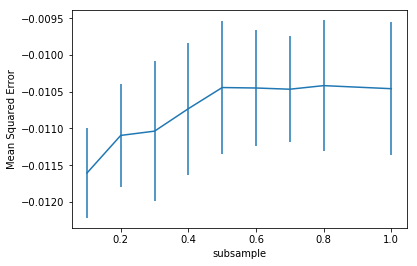

In [35]:
# plot
plt.errorbar(subsample, means, yerr=stds)
plt.legend()
plt.xlabel('subsample')
plt.ylabel('Mean Squared Error')
# print scores

In [36]:
%%time
from sklearn.model_selection import GridSearchCV
boost = xgb.XGBRegressor(n_estimators=100, max_depth=2, learning_rate=0.1, subsample=0.8)
colsample_bytree = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
tuned_parameters = dict(colsample_bytree=colsample_bytree)
grid = GridSearchCV(boost, tuned_parameters, cv=3, scoring=rmsle_loss, n_jobs=-1, verbose=2)
grid.fit(data_matrix, train['SalePrice'])

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] colsample_bytree=0.1 ............................................
[CV] colsample_bytree=0.1 ............................................
[CV] colsample_bytree=0.1 ............................................
[CV] colsample_bytree=0.2 ............................................
[CV] ............................. colsample_bytree=0.1, total=   9.3s
[CV] colsample_bytree=0.2 ............................................
[CV] ............................. colsample_bytree=0.1, total=   9.2s
[CV] colsample_bytree=0.2 ............................................
[CV] ............................. colsample_bytree=0.1, total=   9.3s
[CV] colsample_bytree=0.3 ............................................
[CV] ............................. colsample_bytree=0.2, total=  11.1s
[CV] colsample_bytree=0.3 ............................................
[CV] ............................. colsample_bytree=0.2, total=  11.1s
[CV] colsample_by

[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  2.7min finished


CPU times: user 24 s, sys: 534 ms, total: 24.5 s
Wall time: 3min 3s


In [37]:
# summarize results
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.010417 using {'colsample_bytree': 1.0}
-0.010748 (0.000846) with: {'colsample_bytree': 0.1}
-0.010740 (0.000759) with: {'colsample_bytree': 0.2}
-0.010591 (0.000887) with: {'colsample_bytree': 0.3}
-0.010554 (0.000847) with: {'colsample_bytree': 0.4}
-0.010714 (0.000842) with: {'colsample_bytree': 0.5}
-0.010651 (0.000732) with: {'colsample_bytree': 0.6}
-0.010585 (0.000725) with: {'colsample_bytree': 0.7}
-0.010598 (0.000887) with: {'colsample_bytree': 0.8}
-0.010417 (0.000890) with: {'colsample_bytree': 1.0}


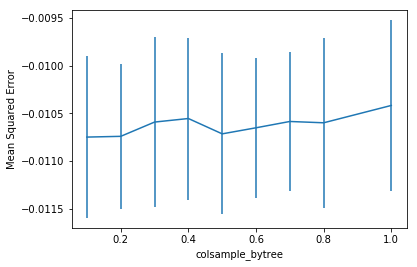

In [38]:
# plot
plt.errorbar(colsample_bytree, means, yerr=stds)
plt.legend()
plt.xlabel('colsample_bytree')
plt.ylabel('Mean Squared Error')
# print scores

In [39]:
%%time
from sklearn.model_selection import GridSearchCV
boost = xgb.XGBRegressor(n_estimators=100, max_depth=2,
                         learning_rate=0.1, subsample=0.8,
                         colsample_bytree=1)
colsample_bylevel = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
tuned_parameters = dict(colsample_bylevel=colsample_bylevel)
grid = GridSearchCV(boost, tuned_parameters, cv=3, scoring=rmsle_loss, n_jobs=-1, verbose=2)
grid.fit(data_matrix, train['SalePrice'])

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] colsample_bylevel=0.1 ...........................................
[CV] colsample_bylevel=0.1 ...........................................
[CV] colsample_bylevel=0.1 ...........................................
[CV] colsample_bylevel=0.2 ...........................................
[CV] ............................ colsample_bylevel=0.1, total=   9.0s
[CV] colsample_bylevel=0.2 ...........................................
[CV] ............................ colsample_bylevel=0.1, total=   9.1s
[CV] colsample_bylevel=0.2 ...........................................
[CV] ............................ colsample_bylevel=0.1, total=   9.1s
[CV] colsample_bylevel=0.3 ...........................................
[CV] ............................ colsample_bylevel=0.2, total=  11.4s
[CV] colsample_bylevel=0.3 ...........................................
[CV] ............................ colsample_bylevel=0.2, total=  11.7s
[CV] colsample_by

[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  2.7min finished


CPU times: user 23.4 s, sys: 453 ms, total: 23.8 s
Wall time: 3min 5s


In [40]:
# summarize results
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.010417 using {'colsample_bylevel': 1.0}
-0.010723 (0.000932) with: {'colsample_bylevel': 0.1}
-0.010464 (0.000854) with: {'colsample_bylevel': 0.2}
-0.010517 (0.000862) with: {'colsample_bylevel': 0.3}
-0.010484 (0.000777) with: {'colsample_bylevel': 0.4}
-0.010543 (0.001068) with: {'colsample_bylevel': 0.5}
-0.010446 (0.000894) with: {'colsample_bylevel': 0.6}
-0.010530 (0.000993) with: {'colsample_bylevel': 0.7}
-0.010497 (0.000958) with: {'colsample_bylevel': 0.8}
-0.010417 (0.000890) with: {'colsample_bylevel': 1.0}


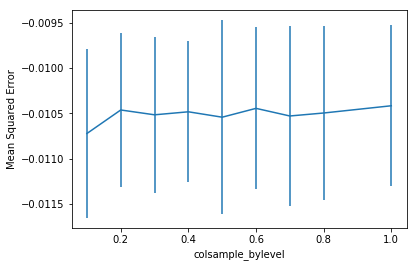

In [41]:
# plot
plt.errorbar(colsample_bylevel, means, yerr=stds)
plt.legend()
plt.xlabel('colsample_bylevel')
plt.ylabel('Mean Squared Error')
# print scores

In [42]:
%%time
params = {}
params['eta'] = 0.1
params['objective'] = 'reg:linear'
params['eval_metric'] = 'rmse'
params['max_depth'] = 2
params['silent'] = 1
params['learning_rate'] = 0.1
params['subsample'] = 0.8
params['colsample_bytree'] = 1
params['colsample_bylevel'] = 1

watchlist = [(d_train, 'train'), (d_test, 'test')]
boost = xgb.train(params, d_train, 10000, watchlist, early_stopping_rounds=100, verbose_eval=10)

[0]	train-rmse:10.3843	test-rmse:10.372
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 100 rounds.
[10]	train-rmse:3.63794	test-rmse:3.63449
[20]	train-rmse:1.2848	test-rmse:1.29076
[30]	train-rmse:0.468604	test-rmse:0.480204
[40]	train-rmse:0.197933	test-rmse:0.224493
[50]	train-rmse:0.1231	test-rmse:0.161746
[60]	train-rmse:0.105212	test-rmse:0.149469
[70]	train-rmse:0.099518	test-rmse:0.146403
[80]	train-rmse:0.095319	test-rmse:0.144984
[90]	train-rmse:0.092218	test-rmse:0.143405
[100]	train-rmse:0.089085	test-rmse:0.142976
[110]	train-rmse:0.086647	test-rmse:0.142476
[120]	train-rmse:0.084124	test-rmse:0.141876
[130]	train-rmse:0.082318	test-rmse:0.141479
[140]	train-rmse:0.080699	test-rmse:0.140976
[150]	train-rmse:0.079011	test-rmse:0.140629
[160]	train-rmse:0.07726	test-rmse:0.140055
[170]	train-rmse:0.075685	test-rmse:0.140689
[180]	train-rmse:0.074357	test-rmse:0.140709
[190]	train-rmse:0.0727

In [43]:
%%time
train_preds = boost.predict(d_test)

CPU times: user 5.1 ms, sys: 2.48 ms, total: 7.58 ms
Wall time: 5.6 ms


In [44]:
%%time
from sklearn.metrics import mean_squared_log_error
print rmsle(y_test, train_preds)

0.0107893111323
CPU times: user 428 µs, sys: 173 µs, total: 601 µs
Wall time: 478 µs


In [45]:
%%time
test['MSSubClass'] = test['MSSubClass'].astype(str)
test_cat_matrix = dv.transform(test[cats].T.to_dict().values())
test[nums] = test[nums].fillna(test[nums].mean())
test_poly = poly.transform(test[nums])
test_data_matrix = hstack([test_cat_matrix, test_poly])
d_test = xgb.DMatrix(test_data_matrix)

CPU times: user 3.23 s, sys: 300 ms, total: 3.53 s
Wall time: 3.54 s


In [46]:
preds = np.expm1(boost.predict(d_test))

In [47]:
submission = pd.DataFrame()
submission['Id'] = test.Id
submission['SalePrice'] = preds

In [48]:
submission.to_csv('submission_xgb.csv', index=False)